In [1]:
#importing packages
import pandas as pd
import numpy as np

In [2]:
Dtrain = pd.read_csv("TrainingSet (IR - 7).csv")
Dtest = pd.read_csv("TestingSet (IR - 7).csv")

In [3]:
print(Dtrain.shape)
print(Dtest.shape)

(193792, 4)
(48448, 4)


In [4]:
Dtrain["Bearing"].value_counts()

Normal                 96896
Inner Race (0.007")    96896
Name: Bearing, dtype: int64

In [5]:
Dtrain["Bearing"].value_counts(normalize=True)*100

Normal                 50.0
Inner Race (0.007")    50.0
Name: Bearing, dtype: float64

In [6]:
Dtest.columns

Index(['Bearing', 'Fault Diameter', 'DE', 'FE'], dtype='object')

In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
labelencoder_train = LabelEncoder()
Dtrain["Bearing"] = labelencoder_train.fit_transform(Dtrain["Bearing"])
#ct = ColumnTransformer([("Bearing", OneHotEncoder(), [0])],    remainder = 'passthrough')
#Dtrain = ct.fit_transform(Dtrain)

In [8]:
Dtrain

,Bearing,Fault Diameter,DE,FE
0,1,0.000,0.064254,0.038625
1,1,0.000,0.063002,0.096769
2,1,0.000,-0.004381,0.127382
3,1,0.000,-0.035882,0.144640
4,1,0.000,-0.023991,0.086702
...,...,...,...,...
193787,0,0.007,1.475073,0.749087
193788,0,0.007,0.102821,0.492064
193789,0,0.007,-1.195685,0.430427
193790,0,0.007,0.214090,0.003287


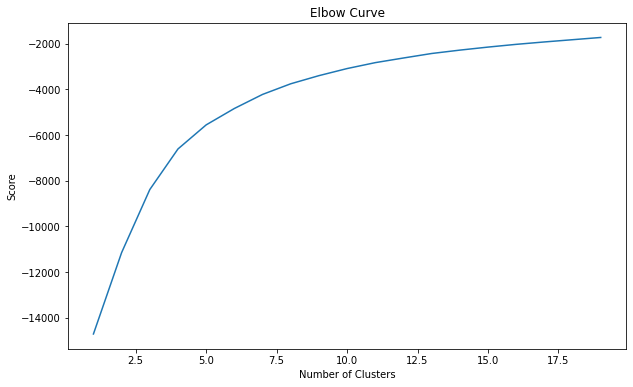

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
data = Dtrain[['Fault Diameter', 'DE', 'FE']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

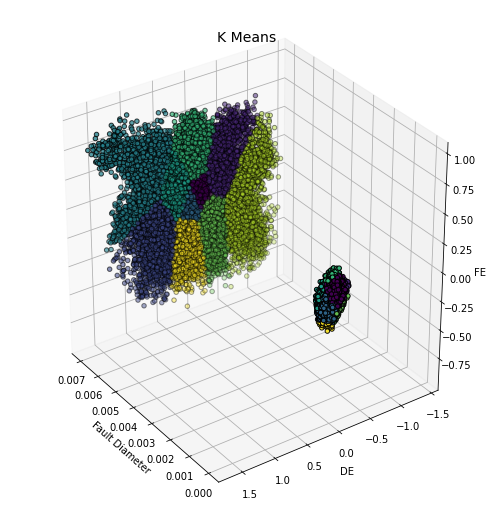

In [10]:
from mpl_toolkits.mplot3d import Axes3D

X = Dtrain[['Fault Diameter', 'DE', 'FE']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
km.predict(X)
labels = km.labels_
#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=30, azim=145)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("Fault Diameter")
ax.set_ylabel("DE")
ax.set_zlabel("FE")
plt.title("K Means", fontsize=14);

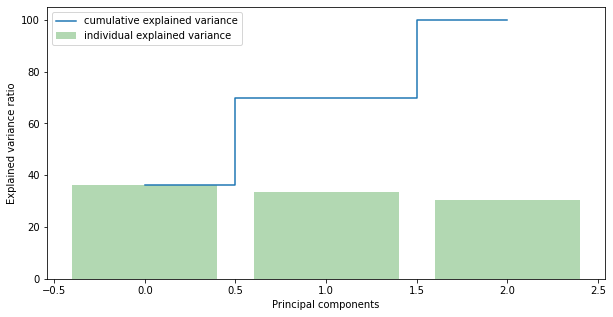

In [11]:
from sklearn.preprocessing import StandardScaler

data = Dtrain[['Fault Diameter', 'DE', 'FE']]

X = data.values
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

C:\Users\leste\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


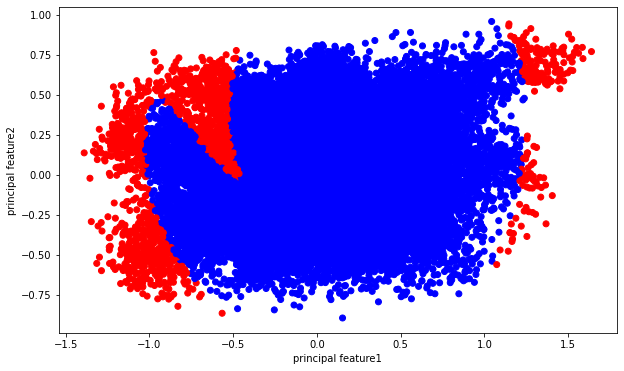

In [12]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[9])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
Dtrain['anomaly1'] = (distance >= threshold).astype(int)

# visualisation of anomaly with cluster view
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(Dtrain['DE'], Dtrain['FE'], c=Dtrain["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

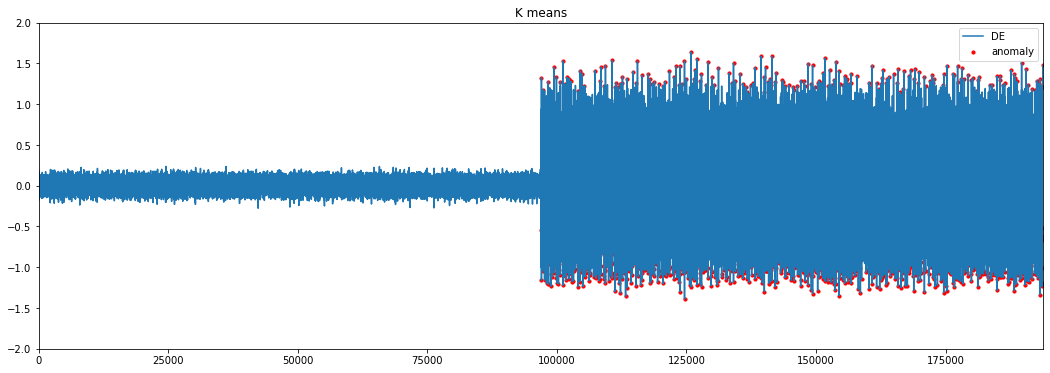

In [13]:
anomalies1 = Dtrain[Dtrain['anomaly1'] == 1]

f, (ax1) = plt.subplots(figsize=(18, 6))
ax1.scatter(anomalies1.index, anomalies1.DE, label='anomaly', color='red', s=10)
ax1.plot(Dtrain.index, Dtrain.DE, label='DE');
plt.axis((0,len(Dtrain.index),-2,2))

plt.title('K means')
plt.legend();
plt.show();

In [14]:
anomalies1

,Bearing,Fault Diameter,DE,FE,anomaly1
97020,0,0.007,-0.537660,0.035955,1
97025,0,0.007,1.322547,0.579793,1
97030,0,0.007,-1.157675,-0.369407,1
97178,0,0.007,-0.916459,-0.555138,1
97181,0,0.007,-0.703994,0.573218,1
...,...,...,...,...,...
193778,0,0.007,1.212416,-0.039242,1
193781,0,0.007,-0.518006,0.182238,1
193785,0,0.007,-1.009209,-0.314345,1
193787,0,0.007,1.475073,0.749087,1


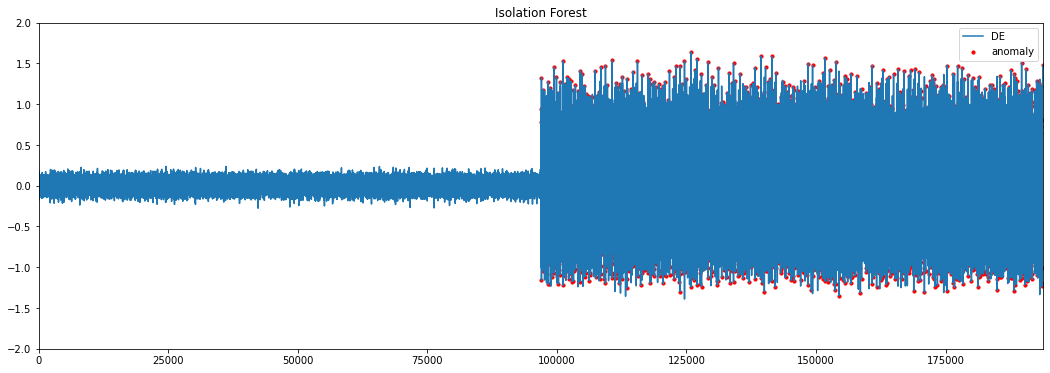

In [15]:
from sklearn.ensemble import IsolationForest

data = Dtrain[['Fault Diameter', 'DE', 'FE']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 
Dtrain['anomaly2'] = pd.Series(model.predict(data))

# visualization
anomalies2 = Dtrain[Dtrain['anomaly2'] == -1]

f, (ax2) = plt.subplots(figsize=(18, 6))
ax2.scatter(anomalies2.index, anomalies2.DE, label='anomaly', color='red', s=10)
ax2.plot(Dtrain.index, Dtrain.DE, label='DE');
plt.axis((0,len(Dtrain.index),-2,2))

plt.title('Isolation Forest')
plt.legend();
plt.show();

In [16]:
anomalies2

,Bearing,Fault Diameter,DE,FE,anomaly1,anomaly2
96949,0,0.007,0.937576,0.503569,0,-1
97024,0,0.007,0.777415,0.567671,0,-1
97025,0,0.007,1.322547,0.579793,1,-1
97030,0,0.007,-1.157675,-0.369407,1,-1
97178,0,0.007,-0.916459,-0.555138,1,-1
...,...,...,...,...,...,...
193574,0,0.007,0.806653,0.559247,0,-1
193785,0,0.007,-1.009209,-0.314345,1,-1
193787,0,0.007,1.475073,0.749087,1,-1
193789,0,0.007,-1.195685,0.430427,1,-1


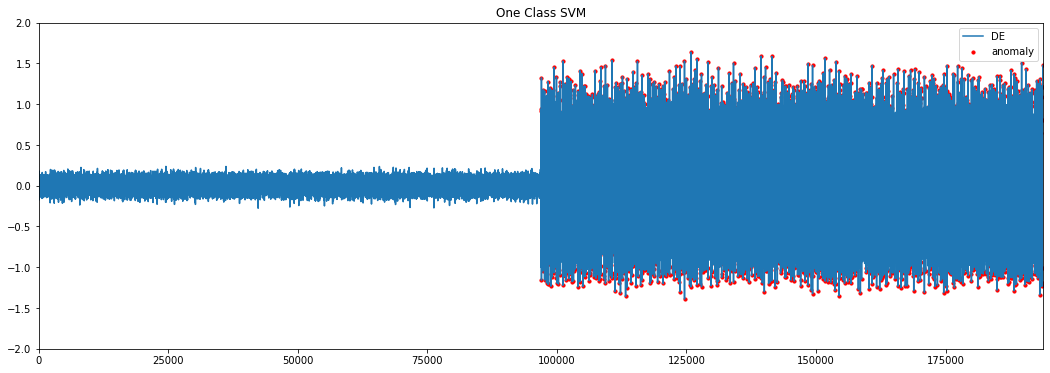

In [17]:
from sklearn.svm import OneClassSVM

data = Dtrain[['Fault Diameter', 'DE', 'FE']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train oneclassSVM 
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(data)
Dtrain['anomaly3'] = pd.Series(model.predict(data))

anomalies3 = Dtrain[Dtrain['anomaly3'] == -1]

f, (ax3) = plt.subplots(figsize=(18, 6))
ax3.scatter(anomalies3.index, anomalies3.DE, label='anomaly', color='red', s=10)
ax3.plot(Dtrain.index, Dtrain.DE, label='DE');
plt.axis((0,len(Dtrain.index),-2,2))

plt.title('One Class SVM')
plt.legend();
plt.show();

In [18]:
anomalies3

,Bearing,Fault Diameter,DE,FE,anomaly1,anomaly2,anomaly3
96949,0,0.007,0.937576,0.503569,0,-1,-1
97025,0,0.007,1.322547,0.579793,1,-1,-1
97028,0,0.007,0.911911,-0.292773,0,1,-1
97030,0,0.007,-1.157675,-0.369407,1,-1,-1
97178,0,0.007,-0.916459,-0.555138,1,-1,-1
...,...,...,...,...,...,...,...
193778,0,0.007,1.212416,-0.039242,1,1,-1
193785,0,0.007,-1.009209,-0.314345,1,-1,-1
193787,0,0.007,1.475073,0.749087,1,-1,-1
193789,0,0.007,-1.195685,0.430427,1,-1,-1


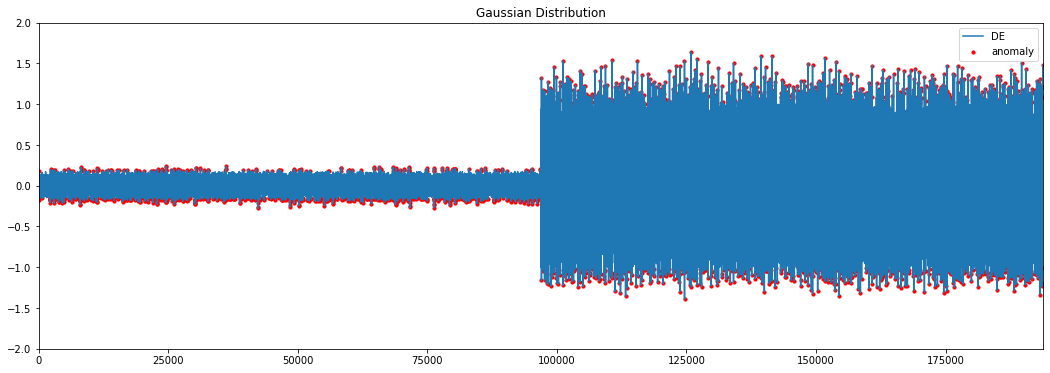

In [19]:
from sklearn.covariance import EllipticEnvelope

df_class0 = Dtrain.loc[Dtrain['Bearing'] == 1, 'DE']
df_class1 = Dtrain.loc[Dtrain['Bearing'] == 0, 'DE']

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

df_class = pd.concat([df_class0, df_class1])

Dtrain['anomaly4'] = df_class['anomaly']

anomalies4 = Dtrain[Dtrain['anomaly4'] == -1]

f, (ax4) = plt.subplots(figsize=(18, 6))
ax4.scatter(anomalies4.index, anomalies4.DE, label='anomaly', color='red', s=10)
ax4.plot(Dtrain.index, Dtrain.DE, label='DE');
plt.axis((0,len(Dtrain.index),-2,2))

plt.title('Gaussian Distribution')
plt.legend();
plt.show();

In [20]:
anomalies4

,Bearing,Fault Diameter,DE,FE,anomaly1,anomaly2,anomaly3,anomaly4
83,1,0.000,-0.175654,0.078073,0,1,1,-1
84,1,0.000,-0.148117,0.048898,0,1,1,-1
94,1,0.000,-0.152915,0.059376,0,1,1,-1
132,1,0.000,0.179826,0.124300,0,1,1,-1
671,1,0.000,-0.155836,0.115260,0,1,1,-1
...,...,...,...,...,...,...,...,...
193561,0,0.007,1.088478,0.092865,0,1,-1,-1
193778,0,0.007,1.212416,-0.039242,1,1,-1,-1
193785,0,0.007,-1.009209,-0.314345,1,-1,-1,-1
193787,0,0.007,1.475073,0.749087,1,-1,-1,-1


In [21]:
a1 = anomalies4[anomalies4['anomaly1'] == 1]
a2 = a1[a1['anomaly2'] == -1]
a3 = a2[a2['anomaly3'] == -1]
anomalies = a3[a3['anomaly4'] == -1]

In [22]:
#anomalies of Kmeans+Isolationforest+oneclassSVM+GaussianDistribution
anomalies

,Bearing,Fault Diameter,DE,FE,anomaly1,anomaly2,anomaly3,anomaly4
97025,0,0.007,1.322547,0.579793,1,-1,-1,-1
97030,0,0.007,-1.157675,-0.369407,1,-1,-1,-1
97245,0,0.007,-1.042996,0.360778,1,-1,-1,-1
97406,0,0.007,1.177167,0.857362,1,-1,-1,-1
97869,0,0.007,-1.117066,-0.223945,1,-1,-1,-1
...,...,...,...,...,...,...,...,...
193412,0,0.007,-1.013595,-0.518362,1,-1,-1,-1
193559,0,0.007,-1.233857,-0.447275,1,-1,-1,-1
193785,0,0.007,-1.009209,-0.314345,1,-1,-1,-1
193787,0,0.007,1.475073,0.749087,1,-1,-1,-1


In [26]:
print("Anomalies")
print("K-means: " + str(anomalies1['anomaly1'].count()))
print("Isolation forest: " + str(anomalies2['anomaly2'].count()))
print("one class SVM: " + str(anomalies3['anomaly3'].count()))
print("Gaussian Distribution: " + str(anomalies4['anomaly4'].count()))

Anomalies
K-means: 1937
Isolation forest: 1938
one class SVM: 1938
Gaussian Distribution: 1937
